In [197]:
import pandas as pd                 # pandas is a dataframe library
import matplotlib.pyplot as plt     # matplotlib.pyplot plots data
import numpy as np                  # numpy provides N-dim object support

# do ploting inline instead of in a separate window
%matplotlib inline

In [198]:
#READ AND PARSE AIRLINE FILE
airline_tweets = pd.read_csv('airline_tweets.csv', usecols=['airline_sentiment','tweet_coord'],encoding='utf-8')
airline_tweets=airline_tweets.dropna()
airline_tweets=airline_tweets.loc[airline_tweets['tweet_coord'] != '[0.0, 0.0]']
sentiment_map = { 'negative' : 0,'neutral' :1,'positive' : 2}
airline_tweets['airline_sentiment'] = airline_tweets['airline_sentiment'].map(sentiment_map)
airline_tweets['tweet_coord'].replace(regex=True,inplace=True,to_replace=r'\[',value=r'')
airline_tweets['tweet_coord'].replace(regex=True,inplace=True,to_replace=r'\]',value=r'')
airline_tweets = airline_tweets.reset_index(drop=True)

split_c = airline_tweets['tweet_coord'].apply(lambda x: x.split(','))
airline_tweets['latitude'] = split_c.apply(lambda x: float(x[0]))
airline_tweets['longitude'] = split_c.apply(lambda x: float(x[1]))
airline_tweets.drop(['tweet_coord'],axis=1)

#READ AND PARSE CITIES
cities = pd.read_csv( "cities.csv", delimiter="," ,header='infer',usecols=['name','latitude','longitude'],encoding='utf-8')
cities=cities.dropna()
cities['city_coord']= cities[['latitude','longitude']].values.tolist()

In [199]:
airline_tweets.describe()

,airline_sentiment,latitude,longitude
count,855.000000,855.000000,855.000000
mean,0.505263,36.526645,-85.553280
std,0.775599,8.108130,32.914574
min,0.000000,-38.027164,-157.918466
25%,0.000000,33.692385,-104.670476
50%,0.000000,38.855809,-84.192432
75%,1.000000,40.697157,-74.279611
max,2.000000,59.382473,151.208213


In [200]:
airline_tweets[0:5]

,airline_sentiment,tweet_coord,latitude,longitude
0,2,"40.74804263, -73.99295302",40.748043,-73.992953
1,0,"42.361016, -71.02000488",42.361016,-71.020005
2,1,"33.94540417, -118.4062472",33.945404,-118.406247
3,0,"33.94209449, -118.40410103",33.942094,-118.404101
4,2,"33.2145038, -96.9321504",33.214504,-96.932150


In [201]:
cities[0:5]

,name,latitude,longitude,city_coord
0,les Escaldes,42.50729,1.53414,"[42.507290000000005, 1.53414]"
1,Andorra la Vella,42.50779,1.52109,"[42.50779, 1.52109]"
2,Umm al Qaywayn,25.56473,55.55517,"[25.564729999999997, 55.55517]"
3,Ras al-Khaimah,25.78953,55.94320,"[25.78953, 55.9432]"
4,Khawr Fakkān,25.33132,56.34199,"[25.33132, 56.34199]"


In [202]:
np.c_? #Translates slice objects to concatenation along the second axis.1 or row

SyntaxError: invalid syntax (<ipython-input-202-913e423ab9de>, line 1)

In [17]:
# find the nearest city to the tweet coorinates usin ckdtree(nearest neighbour) and query(Euclidean)
from scipy.spatial import cKDTree

def closest_pts(setA_lat, setA_lng, setB_lat, setB_lng):
    a_x = setA_lat.values
    a_y = setA_lng.values
    b_x = setB_lat.values
    b_y = setB_lng.values
    #print(a_x[0:5])
    a = np.c_[a_x, a_y]
    #print(a) [[  40.74804263  -73.99295302]
    b = np.c_[b_x, b_y]
    indx = cKDTree(b).query(a,k=1,p=2)[1] # this returns array in position0 and index in position 1
    #print(indx)
    return pd.Series(b_x[indx]), pd.Series(b_y[indx]),pd.Series(cities['name'][indx])

In [205]:
setA_lat = airline_tweets['latitude']
setA_lng =  airline_tweets['longitude']

setB_lat = cities['latitude']
setB_lng =  cities['longitude']

In [19]:
c_x,c_y,c_n = closest_pts(setA_lat, setA_lng, setB_lat, setB_lng)

In [20]:
c_n = c_n.reset_index(drop=True)
c_n[0:5]

0    New York City
1          Chelsea
2       El Segundo
3       El Segundo
4           Frisco
Name: name, dtype: object

In [21]:
airline_tweets['nearest_latitude'] = c_x
airline_tweets['nearest_longitude'] = c_y
airline_tweets['nearest_city'] =c_n

In [22]:
airline_tweets[0:10]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
0,2,"40.74804263, -73.99295302",40.748043,-73.992953,40.71427,-74.00597,New York City
1,0,"42.361016, -71.02000488",42.361016,-71.020005,42.39176,-71.03283,Chelsea
2,1,"33.94540417, -118.4062472",33.945404,-118.406247,33.91918,-118.41647,El Segundo
3,0,"33.94209449, -118.40410103",33.942094,-118.404101,33.91918,-118.41647,El Segundo
4,2,"33.2145038, -96.9321504",33.214504,-96.932150,33.15067,-96.82361,Frisco
5,1,"34.0219817, -118.38591198",34.021982,-118.385912,34.02112,-118.39647,Culver City
6,1,"33.57963333, -117.73024772",33.579633,-117.730248,33.56504,-117.72712,Aliso Viejo
7,0,"40.6413712, -73.78311558",40.641371,-73.783116,40.66312,-73.76221,Springfield Gardens
8,2,"36.08457854, -115.13780136",36.084579,-115.137801,36.09719,-115.14666,Paradise
9,1,"37.79374402, -122.39327564",37.793744,-122.393276,37.77493,-122.41942,San Francisco


In [23]:
feature_df = airline_tweets[['nearest_city']]

In [24]:
label_df = airline_tweets['airline_sentiment']

In [25]:
print(type(feature_df))
print(type(label_df))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [26]:
# feature encoding
features = pd.get_dummies(feature_df, columns=["nearest_city"])
features[0:5]

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Whitestone,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
col = features.columns.values  # use this if u have to get feature names
feature_names = pd.Series(col)
type(feature_names)

pandas.core.series.Series

In [28]:
# label encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(label_df.values)
print(list(le.classes_))
labels = le.transform(label_df)
labels[0:5]

[0, 1, 2]


array([2, 0, 1, 0, 2])

In [29]:
type(labels)

numpy.ndarray

In [30]:
label_df.values[0:5]

array([2, 0, 1, 0, 2])

In [31]:
# luigi
features['labels'] = labels

In [387]:
features[0:5]  # save this to csv

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville,labels
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [388]:
labels = features['labels']
labels = np.array(labels)
features= features.drop(['labels'],axis=1)

In [389]:
features[0:5]

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Whitestone,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [390]:
# remove if does not work
#labels = label_df.values has same effect as above transformation

In [391]:
print(features.shape)
print(labels.shape)

(855, 291)
(855,)


In [392]:
features[0:5]

,nearest_city_Addison,nearest_city_Aldine,nearest_city_Aliso Viejo,nearest_city_Allen,nearest_city_American Fork,nearest_city_Anaheim,nearest_city_Angeles City,nearest_city_Annapolis,nearest_city_Arbutus,nearest_city_Ashford,...,nearest_city_Whitestone,nearest_city_Williamsport,nearest_city_Willow Grove,nearest_city_Windsor,nearest_city_Winnipeg,nearest_city_Winter Park,nearest_city_Wolverhampton,nearest_city_Woodstock,nearest_city_Xiuying,nearest_city_Zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
from sklearn.cross_validation import train_test_split?

In [ ]:
from sklearn.cross_validation import train_test_split

In [245]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.40, random_state=0)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [394]:
X_train.shape

(513, 291)

In [395]:
print(type(X_train),X_train.shape)
print(type(y_train),y_train.shape)
print(type(X_test),X_test.shape)
print(type(y_test),y_test.shape)

<class 'numpy.ndarray'> (513, 291)
<class 'numpy.ndarray'> (513,)
<class 'numpy.ndarray'> (342, 291)
<class 'numpy.ndarray'> (342,)


In [396]:
feature_names

0                  nearest_city_Addison
1                   nearest_city_Aldine
2              nearest_city_Aliso Viejo
3                    nearest_city_Allen
4            nearest_city_American Fork
5                  nearest_city_Anaheim
6             nearest_city_Angeles City
7                nearest_city_Annapolis
8                  nearest_city_Arbutus
9                  nearest_city_Ashford
10                 nearest_city_Ashland
11               nearest_city_Ashtabula
12              nearest_city_Atascocita
13                 nearest_city_Augusta
14                  nearest_city_Aurora
15                  nearest_city_Austin
16               nearest_city_Baltimore
17               nearest_city_Battersea
18                nearest_city_Bellaire
19          nearest_city_Belvedere Park
20           nearest_city_Benito Juarez
21             nearest_city_Bensenville
22                nearest_city_Bergeijk
23           nearest_city_Beverly Hills
24              nearest_city_Birmingham


In [397]:
import pickle
from sklearn import metrics

# save the classifier
# save the model to disk
filename = 'finalized_model.pkl'
#pickle.dump(nb_model, open(filename, 'wb'))   

# load the model from disk
nb_model = pickle.load(open(filename, 'rb'))
ModelScore = nb_model.score(X_test, y_test)
print(ModelScore)

0.616959064327


In [398]:
# predict values using the training data
nb_predict_class = nb_model.predict(X_test)
# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_class)))
print()

Accuracy: 0.6170



In [399]:
nb_predict_class[0:5]

array([0, 0, 0, 0, 0])

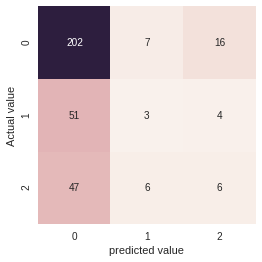

In [400]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_test,nb_predict_class)
sns.heatmap(mat,square=True,annot=True,fmt='g',cbar=False)
#plt(figsize=(5,5))
plt.xlabel('predicted value')
plt.ylabel('Actual value')

In [401]:
# Although the accuracy is low, this fits the data really well.

In [402]:
from sklearn.model_selection import cross_val_score
cross_val_score(nb_model,X_test, y_test)

array([ 0.59130435,  0.51754386,  0.62831858])

In [403]:
probabilities = nb_model.predict_proba(X_test)

In [404]:
nb_model.classes_

array([0, 1, 2])

In [405]:
probabilities[0:50]

array([[ 0.47869523,  0.24503041,  0.27627436],
       [ 0.47869523,  0.24503041,  0.27627436],
       [ 0.60312965,  0.20529483,  0.19157551],
       [ 0.52889184,  0.22248165,  0.24862651],
       [ 0.51230683,  0.16893121,  0.31876196],
       [ 0.50166131,  0.31643513,  0.18190356],
       [ 0.58506723,  0.17660794,  0.23832483],
       [ 0.47869523,  0.24503041,  0.27627436],
       [ 0.47869523,  0.24503041,  0.27627436],
       [ 0.4357422 ,  0.28441945,  0.27983835],
       [ 0.43375593,  0.19148069,  0.37476338],
       [ 0.52889184,  0.22248165,  0.24862651],
       [ 0.52889184,  0.22248165,  0.24862651],
       [ 0.60287414,  0.18872114,  0.20840472],
       [ 0.47869523,  0.24503041,  0.27627436],
       [ 0.63079905,  0.17584005,  0.19336089],
       [ 0.50139179,  0.35738522,  0.14122299],
       [ 0.47869523,  0.24503041,  0.27627436],
       [ 0.47869523,  0.24503041,  0.27627436],
       [ 0.63079905,  0.17584005,  0.19336089],
       [ 0.50166131,  0.31643513,  0.181

In [406]:
probabilities.shape

(342, 3)

In [407]:
classes = nb_model.classes_

In [408]:
X_test[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [409]:
predict = nb_model.predict(X_test)

In [410]:
predict[0:5]

array([0, 0, 0, 0, 0])

In [411]:
len(feature_names)

291

In [412]:
type(feature_names)

pandas.core.series.Series

In [413]:
type(probabilities)

numpy.ndarray

In [414]:
probabilities.shape

(342, 3)

In [415]:
probabilities_df = pd.DataFrame(probabilities,columns=['negative','neutral','positive'])

In [416]:
probabilities_df[0:5]

,negative,neutral,positive
0,0.478695,0.245030,0.276274
1,0.478695,0.245030,0.276274
2,0.603130,0.205295,0.191576
3,0.528892,0.222482,0.248627
4,0.512307,0.168931,0.318762


In [417]:
feature_name_series = pd.Series(feature_names)

In [418]:
probabilities_df['cities'] = feature_name_series

In [419]:
probabilities_df[0:5]

,negative,neutral,positive,cities
0,0.478695,0.245030,0.276274,nearest_city_Addison
1,0.478695,0.245030,0.276274,nearest_city_Aldine
2,0.603130,0.205295,0.191576,nearest_city_Aliso Viejo
3,0.528892,0.222482,0.248627,nearest_city_Allen
4,0.512307,0.168931,0.318762,nearest_city_American Fork


In [420]:
city_probability = probabilities_df[['cities','negative','neutral','positive']]

In [421]:
city_probability[0:5]

,cities,negative,neutral,positive
0,nearest_city_Addison,0.478695,0.245030,0.276274
1,nearest_city_Aldine,0.478695,0.245030,0.276274
2,nearest_city_Aliso Viejo,0.603130,0.205295,0.191576
3,nearest_city_Allen,0.528892,0.222482,0.248627
4,nearest_city_American Fork,0.512307,0.168931,0.318762


In [422]:
type(predict)

numpy.ndarray

In [423]:
predictions = pd.Series(predict)
predictions[0:5]

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [424]:
city_probability['model_predictions'] = predictions

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [425]:
city_probability[0:10]

,cities,negative,neutral,positive,model_predictions
0,nearest_city_Addison,0.478695,0.245030,0.276274,0
1,nearest_city_Aldine,0.478695,0.245030,0.276274,0
2,nearest_city_Aliso Viejo,0.603130,0.205295,0.191576,0
3,nearest_city_Allen,0.528892,0.222482,0.248627,0
4,nearest_city_American Fork,0.512307,0.168931,0.318762,0
5,nearest_city_Anaheim,0.501661,0.316435,0.181904,0
6,nearest_city_Angeles City,0.585067,0.176608,0.238325,0
7,nearest_city_Annapolis,0.478695,0.245030,0.276274,0
8,nearest_city_Arbutus,0.478695,0.245030,0.276274,0
9,nearest_city_Ashford,0.435742,0.284419,0.279838,0


In [426]:
y_test[0:10]

array([0, 1, 0, 0, 2, 0, 1, 2, 2, 2])

In [427]:
sentiment_map = { 0:'negative',1:'neutral',2:'positive'}
city_probability['sentiment_prediction'] = city_probability['model_predictions'].map(sentiment_map)

/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [428]:
city_probability[0:10]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
0,nearest_city_Addison,0.478695,0.245030,0.276274,0,negative
1,nearest_city_Aldine,0.478695,0.245030,0.276274,0,negative
2,nearest_city_Aliso Viejo,0.603130,0.205295,0.191576,0,negative
3,nearest_city_Allen,0.528892,0.222482,0.248627,0,negative
4,nearest_city_American Fork,0.512307,0.168931,0.318762,0,negative
5,nearest_city_Anaheim,0.501661,0.316435,0.181904,0,negative
6,nearest_city_Angeles City,0.585067,0.176608,0.238325,0,negative
7,nearest_city_Annapolis,0.478695,0.245030,0.276274,0,negative
8,nearest_city_Arbutus,0.478695,0.245030,0.276274,0,negative
9,nearest_city_Ashford,0.435742,0.284419,0.279838,0,negative


In [429]:
# save all cities with their probabilitiy classes, model prediction and sentiment prediction
city_probability.to_csv('city_probability.csv')
# save a sorted list of cities by the predicted positive sentiment score to the output file
predicted_positive = city_probability[city_probability['model_predictions'] == 2]
sorted_predicted_positive = predicted_positive.sort_values(['positive'], ascending=[False])
sorted_predicted_positive.to_csv('sorted_predicted_positive.csv')

In [430]:
sorted_predicted_positive[0:10]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
319,NaN,0.327214,0.180152,0.492634,2,positive
158,nearest_city_Millbrae,0.327214,0.180152,0.492634,2,positive
224,nearest_city_San Carlos Park,0.327214,0.180152,0.492634,2,positive
269,nearest_city_Waterford,0.370089,0.170305,0.459606,2,positive
246,nearest_city_Springfield Gardens,0.370089,0.170305,0.459606,2,positive
38,nearest_city_Burbank,0.370089,0.170305,0.459606,2,positive
226,nearest_city_San Francisco,0.441971,0.106090,0.451939,2,positive
242,nearest_city_South Jordan,0.441971,0.106090,0.451939,2,positive
298,NaN,0.441971,0.106090,0.451939,2,positive
274,nearest_city_West Raleigh,0.441971,0.106090,0.451939,2,positive


In [431]:
predicted_positive = city_probability[(city_probability['model_predictions'] == 2) & (city_probability['cities'].notnull())]
sorted_predicted_positive = predicted_positive.sort_values(['positive'], ascending=[False])
sorted_predicted_positive[0:10]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
224,nearest_city_San Carlos Park,0.327214,0.180152,0.492634,2,positive
158,nearest_city_Millbrae,0.327214,0.180152,0.492634,2,positive
38,nearest_city_Burbank,0.370089,0.170305,0.459606,2,positive
269,nearest_city_Waterford,0.370089,0.170305,0.459606,2,positive
246,nearest_city_Springfield Gardens,0.370089,0.170305,0.459606,2,positive
201,nearest_city_Portland,0.441971,0.106090,0.451939,2,positive
274,nearest_city_West Raleigh,0.441971,0.106090,0.451939,2,positive
242,nearest_city_South Jordan,0.441971,0.106090,0.451939,2,positive
226,nearest_city_San Francisco,0.441971,0.106090,0.451939,2,positive
217,nearest_city_Roswell,0.441971,0.106090,0.451939,2,positive


In [435]:
predicted_positive = city_probability[(city_probability['cities'].notnull())]
sorted_predicted_positive = predicted_positive.sort_values(['positive'], ascending=[False])
sorted_predicted_positive[0:1000]

,cities,negative,neutral,positive,model_predictions,sentiment_prediction
224,nearest_city_San Carlos Park,0.327214,0.180152,0.492634,2,positive
158,nearest_city_Millbrae,0.327214,0.180152,0.492634,2,positive
38,nearest_city_Burbank,0.370089,0.170305,0.459606,2,positive
269,nearest_city_Waterford,0.370089,0.170305,0.459606,2,positive
246,nearest_city_Springfield Gardens,0.370089,0.170305,0.459606,2,positive
169,nearest_city_New York City,0.441971,0.106090,0.451939,2,positive
201,nearest_city_Portland,0.441971,0.106090,0.451939,2,positive
242,nearest_city_South Jordan,0.441971,0.106090,0.451939,2,positive
62,nearest_city_Corpus Christi,0.441971,0.106090,0.451939,2,positive
162,nearest_city_Morristown,0.441971,0.106090,0.451939,2,positive


In [432]:
#sorted_predicted_positive['positive'].astype('float')
feature_names[224]

'nearest_city_San Carlos Park'

In [433]:
# validate the column mapping and matched predictions
airline_tweets[airline_tweets['nearest_city'] =='American Fork']

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
297,2,"40.35805521, -111.78241283",40.358055,-111.782413,40.3769,-111.79576,American Fork


In [361]:
airline_tweets[airline_tweets['nearest_city'] =='Aldine'][:1]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
31,1,"29.98386923, -95.33729612",29.983869,-95.337296,29.93245,-95.38021,Aldine


In [362]:
sorted_predicted_positive.count()

cities               23
negative             23
neutral              23
positive             23
model_predictions    23
dtype: int64

#Fitting GNB
from sklearn.naive_bayes import GaussianNB
# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# predict values using the training data
nb_predict_class = nb_model.predict(X_test)

# import the performance metrics library
from sklearn import metrics
# Accuracy
print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_class)))
print()

In [366]:
np.version.version

'1.12.1'

In [436]:
airline_tweets[0:10]

,airline_sentiment,tweet_coord,latitude,longitude,nearest_latitude,nearest_longitude,nearest_city
0,2,"40.74804263, -73.99295302",40.748043,-73.992953,40.71427,-74.00597,New York City
1,0,"42.361016, -71.02000488",42.361016,-71.020005,42.39176,-71.03283,Chelsea
2,1,"33.94540417, -118.4062472",33.945404,-118.406247,33.91918,-118.41647,El Segundo
3,0,"33.94209449, -118.40410103",33.942094,-118.404101,33.91918,-118.41647,El Segundo
4,2,"33.2145038, -96.9321504",33.214504,-96.932150,33.15067,-96.82361,Frisco
5,1,"34.0219817, -118.38591198",34.021982,-118.385912,34.02112,-118.39647,Culver City
6,1,"33.57963333, -117.73024772",33.579633,-117.730248,33.56504,-117.72712,Aliso Viejo
7,0,"40.6413712, -73.78311558",40.641371,-73.783116,40.66312,-73.76221,Springfield Gardens
8,2,"36.08457854, -115.13780136",36.084579,-115.137801,36.09719,-115.14666,Paradise
9,1,"37.79374402, -122.39327564",37.793744,-122.393276,37.77493,-122.41942,San Francisco


In [437]:
cities[0:10]

,name,latitude,longitude,city_coord
0,les Escaldes,42.50729,1.53414,"[42.507290000000005, 1.53414]"
1,Andorra la Vella,42.50779,1.52109,"[42.50779, 1.52109]"
2,Umm al Qaywayn,25.56473,55.55517,"[25.564729999999997, 55.55517]"
3,Ras al-Khaimah,25.78953,55.94320,"[25.78953, 55.9432]"
4,Khawr Fakkān,25.33132,56.34199,"[25.33132, 56.34199]"
5,Dubai,25.06570,55.17128,"[25.0657, 55.17128]"
6,Dibba Al-Fujairah,25.59246,56.26176,"[25.59246, 56.261759999999995]"
7,Dibba Al-Hisn,25.61955,56.27291,"[25.61955, 56.272909999999996]"
8,Sharjah,25.33737,55.41206,"[25.33737, 55.41206]"
9,Ar Ruways,24.11028,52.73056,"[24.11028, 52.73056]"


In [32]:
setA_lat = airline_tweets['latitude'][0:5]
setA_lon = airline_tweets['longitude'][0:5]
setA_lat = setA_lat.values
setA_lon = setA_lon.values

In [33]:
setB_lat = airline_tweets['nearest_latitude'][0:15]
setB_lon = airline_tweets['nearest_longitude'][0:15]
setB_lat = setB_lat.values
setB_lon = setB_lon.values

In [34]:
setA = np.c_[setA_lat,setA_lon]
setA

array([[  40.74804263,  -73.99295302],
       [  42.361016  ,  -71.02000488],
       [  33.94540417, -118.4062472 ],
       [  33.94209449, -118.40410103],
       [  33.2145038 ,  -96.9321504 ]])

In [35]:
setB = np.c_[setB_lat,setB_lon]
setB

array([[  40.71427,  -74.00597],
       [  42.39176,  -71.03283],
       [  33.91918, -118.41647],
       [  33.91918, -118.41647],
       [  33.15067,  -96.82361],
       [  34.02112, -118.39647],
       [  33.56504, -117.72712],
       [  40.66312,  -73.76221],
       [  36.09719, -115.14666],
       [  37.77493, -122.41942],
       [  26.05231,  -80.14393],
       [  33.91918, -118.41647],
       [  51.05011, -114.08529],
       [  40.66312,  -73.76221],
       [  33.91918, -118.41647]])

In [36]:
type(setA)
type(setB)

numpy.ndarray

In [37]:
from scipy.spatial import distance
def euclidean4(vector1, vector2):
    ''' use scipy to calculate the euclidean distance. '''
    dist = distance.euclidean(vector1, vector2)
    return dist

In [63]:
for i in setA:
    dist_list = []
    idx=0
    #print(i)
    for j in setB:
        dst = euclidean4(i,j)
        print("for each :",i," : ",j ," didtance :",dst)
        dist_list.append(euclidean4(i,j))
    #idx = (dist_list.index(min(dist_list)))
    print("distance is ",min(dist_list))
    

for each : [ 40.74804263 -73.99295302]  :  [ 40.71427 -74.00597]  didtance : 0.0361943684215806
for each : [ 40.74804263 -73.99295302]  :  [ 42.39176 -71.03283]  didtance : 3.3858728691393027
for each : [ 40.74804263 -73.99295302]  :  [  33.91918 -118.41647]  didtance : 44.94532484799457
for each : [ 40.74804263 -73.99295302]  :  [  33.91918 -118.41647]  didtance : 44.94532484799457
for each : [ 40.74804263 -73.99295302]  :  [ 33.15067 -96.82361]  didtance : 24.0615662212063
for each : [ 40.74804263 -73.99295302]  :  [  34.02112 -118.39647]  didtance : 44.91017488568881
for each : [ 40.74804263 -73.99295302]  :  [  33.56504 -117.72712]  didtance : 44.320118323591025
for each : [ 40.74804263 -73.99295302]  :  [ 40.66312 -73.76221]  didtance : 0.2458743466993661
for each : [ 40.74804263 -73.99295302]  :  [  36.09719 -115.14666]  didtance : 41.41567370430764
for each : [ 40.74804263 -73.99295302]  :  [  37.77493 -122.41942]  didtance : 48.51764733450805
for each : [ 40.74804263 -73.992953

In [190]:
import time

def find_min_dist():
    start_time = time.time()
    for i in setA:
        dist = {}
        idx=0
        #print(i)
        for j in setB: # this second loop can be avoided using np and coe be made more than 10 times faster
            dst = euclidean4(i,j)
            #print("for each :",i," : ",j ," didtance :",dst)
            dist[idx] = (euclidean4(i,j))
            idx+=1
        #print(dist)
        #min(d, key=d.get)
        minVal = (dist.get('value',(min(dist.values()))))
        for key, val in dist.items():    # for name, age in list.items():  (for Python 3.x)
            if val == minVal:
                print (key)
    print("--- %s seconds ---" % (time.time() - start_time))

In [191]:
find_min_dist()

0
1
2
3
11
14
2
3
11
14
4
--- 0.01801300048828125 seconds ---


In [192]:
import math # more than 10 times faster
from sklearn.metrics.pairwise import euclidean_distances
def find_min_dist_np():
    start_time = time.time()
    eqdst = []
    for i in setA:
        dist = {}
        idx=0
        #new_np = setB*i
        var = euclidean_distances(i,setB) # making use of broadcast available in numpy
        eqdst.append(np.min(var))
    print (eqdst)
    print("--- %s seconds ---" % (time.time() - start_time))
        #print(i)


In [193]:
find_min_dist_np()

[0.036194368439292073, 0.033311818316974336, 0.028146273848231155, 0.026039686498695303, 0.12591970638198283]
--- 0.007544755935668945 seconds ---


/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/vijay/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1

In [194]:
#%timeit find_min_dist_np()


In [157]:
#setB.shape

(15, 2)